<a href="https://colab.research.google.com/github/Sanz-8/Jet-Classification-using-Machine-Learning/blob/main/Classification_XGBoosts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # In this notebook,let's try to distinguish the jets from the background using a powerful ML algorithm, XGBoosts Classifier.

In [1]:

from huggingface_hub import login
from google.colab import userdata

token = userdata.get('token_name')
login(token=token)

In [2]:
# Loading the data from the Hugging Face
import pandas as pd

splits = {'train': 'train.parquet', 'validation': 'validation.parquet', 'test': 'test.parquet'}
df_train = pd.read_parquet("hf://datasets/dl4phys/top_tagging/" + splits["train"])
df_val=pd.read_parquet("hf://datasets/dl4phys/top_tagging/" + splits["validation"])
df_test=pd.read_parquet("hf://datasets/dl4phys/top_tagging/" + splits["test"])


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df_train.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
0,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


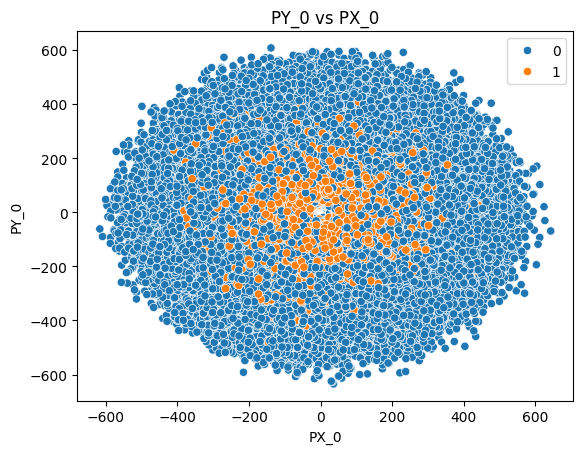

In [66]:
#Plotting the momentum along the X-axis against the Y-axis
sns.scatterplot(x=df_train['PX_0'],y=df_train['PY_0'],hue=df_train['is_signal_new'])
plt.title('PY_0 vs PX_0')
plt.legend(loc='upper right')

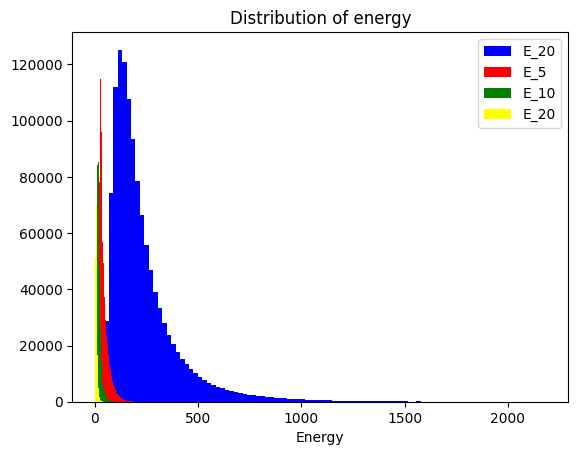

In [25]:
#The distribution of energy for various particles
plt.title('Distribution of energy')
plt.hist(df_train['E_0'],bins=100,color='blue')
plt.hist(df_train['E_5'],bins=100,color='red')
plt.hist(df_train['E_10'],bins=100,color='green')
plt.hist(df_train['E_20'],bins=100,color='yellow')
plt.legend(['E_20','E_5','E_10','E_20'])
plt.xlabel('Energy')
plt.show()

In [27]:
#Getting the energy for the signal and background
E_1_sig=df_train[df_train['is_signal_new']==1]['E_1']
E_1_bkg=df_train[df_train['is_signal_new']==0]['E_1']

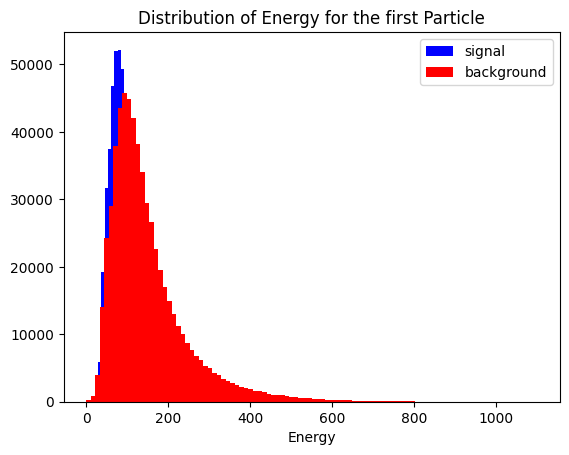

In [28]:
#Plotting the energy of the first particle  for both signal and background
plt.title('Distribution of Energy for the first Particle')
plt.hist(E_1_sig,bins=100,color='blue',label='signal')
plt.hist(E_1_bkg,bins=100,color='red',label='background')
plt.legend(['signal','background'])
plt.xlabel('Energy')
plt.show()

In [30]:
E_20_sig=df_train[df_train['is_signal_new']==1]['E_20']
E_20_bkg=df_train[df_train['is_signal_new']==0]['E_20']

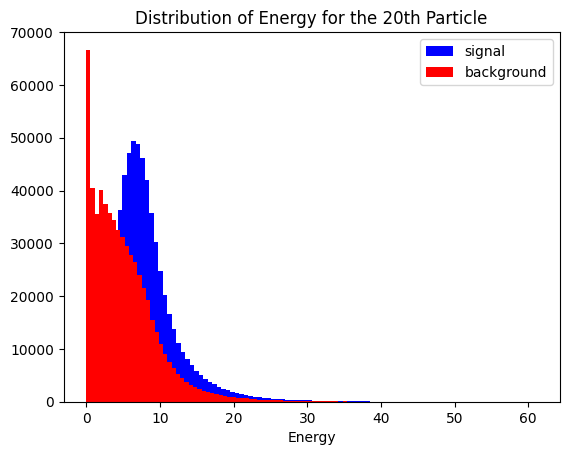

In [31]:
#Checking the energy of the  20th particle for both signal and background
plt.title('Distribution of Energy for the 20th Particle')
plt.hist(E_20_sig,bins=100,color='blue',label='signal')
plt.hist(E_20_bkg,bins=100,color='red',label='background')
plt.legend(['signal','background'])
plt.xlabel('Energy')
plt.show()

Selecting only 50% of the 1.2M data to test the XGBoost due to computational constraint

In [35]:
train_indices=np.random.choice(df_train.index,size=int(len(df_train)*0.5),replace=False)
val_indices=np.random.choice(df_val.index,size=int(len(df_val)*0.1),replace=False)
test_indices=np.random.choice(df_test.index,size=int(len(df_test)*0.1),replace=False)

In [36]:
train=df_train.loc[train_indices]
val=df_val.loc[val_indices]
test=df_test.loc[test_indices]

In [37]:
# Defining the target variable
y_train=train['is_signal_new']
y_val=val['is_signal_new']
y_test=test['is_signal_new']

In [38]:
# Defining the datasets by dropping all the features that strongly correlates with the jets
X_train=train.drop(['truthE','truthPX','truthPY',	'truthPZ','ttv','is_signal_new'],axis=1)
X_val=val.drop(['truthE','truthPX','truthPY',	'truthPZ','ttv','is_signal_new'],axis=1)
X_test=test.drop(['truthE','truthPX','truthPY',	'truthPZ','ttv','is_signal_new'],axis=1)

In [39]:
X_train.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,PY_197,PZ_197,E_198,PX_198,PY_198,PZ_198,E_199,PX_199,PY_199,PZ_199
580188,257.077271,-89.061287,-215.408722,108.424553,146.387329,-54.832272,-123.076103,57.227139,88.102692,-30.206669,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1148999,367.842346,327.995758,-130.348618,103.614685,182.974213,163.037064,-64.587364,52.220200,37.281811,33.397312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1108886,86.011803,53.355053,27.282415,61.700390,76.037109,47.085011,25.159435,54.144680,51.658966,37.598991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1069261,163.672470,-1.014573,-151.960068,60.792965,82.170052,-2.874448,-64.090034,51.343174,83.231049,-4.007126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59622,96.255615,60.357609,-74.934181,2.640309,86.784920,38.381207,-75.385124,19.380104,32.037189,17.626867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train.head()

,is_signal_new
582514,0
296879,1
970182,1
965459,1
711449,0


In [40]:
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score

In [41]:
#Let's see how the well does the model perform on the default settings of XGBClassifier
model_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    early_stopping_rounds=10

)


model_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)]
)

[0]	validation_0-logloss:0.62851
[1]	validation_0-logloss:0.59296
[2]	validation_0-logloss:0.57148
[3]	validation_0-logloss:0.55800
[4]	validation_0-logloss:0.54857
[5]	validation_0-logloss:0.54219
[6]	validation_0-logloss:0.53765
[7]	validation_0-logloss:0.53448
[8]	validation_0-logloss:0.53221
[9]	validation_0-logloss:0.52986
[10]	validation_0-logloss:0.52860
[11]	validation_0-logloss:0.52634
[12]	validation_0-logloss:0.52360
[13]	validation_0-logloss:0.52206
[14]	validation_0-logloss:0.52097
[15]	validation_0-logloss:0.51925
[16]	validation_0-logloss:0.51742
[17]	validation_0-logloss:0.51550
[18]	validation_0-logloss:0.51488
[19]	validation_0-logloss:0.51275
[20]	validation_0-logloss:0.50960
[21]	validation_0-logloss:0.50902
[22]	validation_0-logloss:0.50684
[23]	validation_0-logloss:0.50485
[24]	validation_0-logloss:0.50330
[25]	validation_0-logloss:0.50213
[26]	validation_0-logloss:0.50101
[27]	validation_0-logloss:0.49785
[28]	validation_0-logloss:0.49705
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [42]:
# Prediction on the test data
y_hat=model_xgb.predict(X_test)

In [43]:
y_hat=model_xgb.predict(X_test)
print('accuracy',accuracy_score(y_test,y_hat))


accuracy 0.8004207920792079


The accuracy of the model with default parameters is 0.800

Let's try to fine tune some of the important parameters

In [45]:
#Let's start with gamma, max_depth and the min_child_weight
params=[{'gamma':[1,3,5],'max_depth':[5,8,10],
         'min_child_weight':[1,5,10,20]}]


In [ ]:
model_xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': 10,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': 1,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 10,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [46]:
# In order to  minimize the computation time when running the GridSearch, let's reduce the training datasets
indices=np.random.choice(X_train.index,size=int(len(X_train)*0.1),replace=False)
X_grid,y_grid=X_train.loc[indices],y_train.loc[indices]


In [47]:
print(len(X_grid))
X_grid.head()

60550


,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,PY_197,PZ_197,E_198,PX_198,PY_198,PZ_198,E_199,PX_199,PY_199,PZ_199
401536,203.473236,-60.860718,-177.090820,-79.600090,92.325935,-43.901451,-58.383129,-56.463715,90.098236,-44.611305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496166,71.532875,-33.411537,-51.570168,36.621563,42.679348,-19.693586,-30.706720,22.153708,33.396259,-9.245536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
679871,178.864334,-89.960526,-12.968511,-154.049896,128.893433,-75.245865,12.838227,-103.859322,114.391747,-63.627460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872247,175.248810,89.092926,125.648010,83.589294,171.491455,55.931641,137.084167,86.538452,57.125134,24.944311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379639,54.528999,35.613724,39.427811,12.268755,50.828915,29.866346,36.773861,18.419100,40.768883,26.798409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Running the grid search for the parameters-gamma,,max_depth,min_child_weight

In [48]:
grid=GridSearchCV(
    estimator=XGBClassifier(objective="binary:logistic",
    eval_metric="logloss"),
    param_grid=params,
    scoring='accuracy',
    cv=4,
    return_train_score=True
)
grid.fit(X_grid,y_grid)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid=[{'gamma': [1, 3, 5], 'max_depth': [5, 8, 10],
                          'min_child_weight': [1, 5, 10, 20]}],
             return_train_score=True, scoring='accuracy')

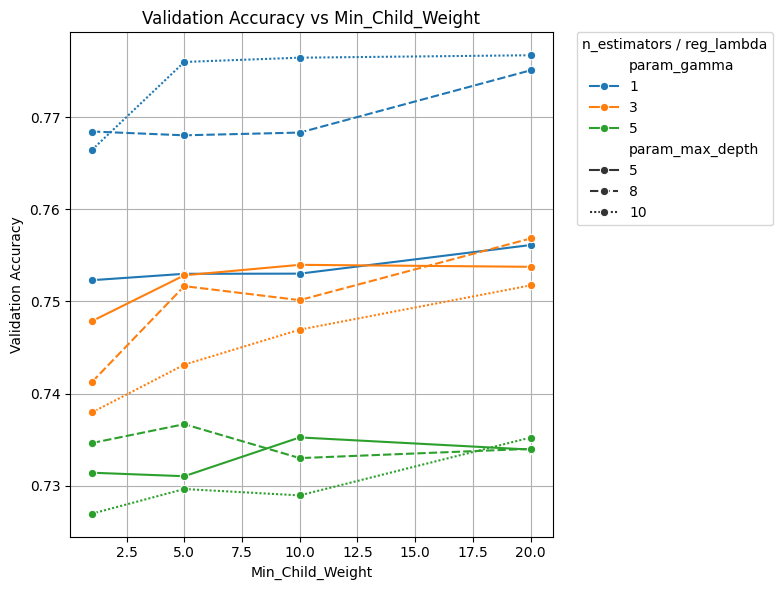

In [52]:
#Now let's plot the result
res=pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x=res['param_min_child_weight'],y=res['mean_test_score'],hue=res['param_gamma'],style=res['param_max_depth'],marker="o",
    palette="tab10")
plt.title("Validation Accuracy vs Min_Child_Weight")
plt.xlabel("Min_Child_Weight")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    title="n_estimators / reg_lambda"
)

plt.tight_layout()
plt.show()

In [49]:
print(grid.best_params_)
print(grid.best_score_)

{'gamma': 1, 'max_depth': 10, 'min_child_weight': 20}
0.776713518621787


In [53]:
#Now, let's see whether the accuracy improves using the above result
model_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    gamma=1,
    max_depth=10,
    min_child_weight=20,
    early_stopping_rounds=10
)
model_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)]
)


[0]	validation_0-logloss:0.62549
[1]	validation_0-logloss:0.58844
[2]	validation_0-logloss:0.56598
[3]	validation_0-logloss:0.55173
[4]	validation_0-logloss:0.54180
[5]	validation_0-logloss:0.53385
[6]	validation_0-logloss:0.52922
[7]	validation_0-logloss:0.52295
[8]	validation_0-logloss:0.51900
[9]	validation_0-logloss:0.51608
[10]	validation_0-logloss:0.51349
[11]	validation_0-logloss:0.50944
[12]	validation_0-logloss:0.50591
[13]	validation_0-logloss:0.50421
[14]	validation_0-logloss:0.49964
[15]	validation_0-logloss:0.49635
[16]	validation_0-logloss:0.49410
[17]	validation_0-logloss:0.49215
[18]	validation_0-logloss:0.49070
[19]	validation_0-logloss:0.48923
[20]	validation_0-logloss:0.48622
[21]	validation_0-logloss:0.48534
[22]	validation_0-logloss:0.48407
[23]	validation_0-logloss:0.48233
[24]	validation_0-logloss:0.47954
[25]	validation_0-logloss:0.47795
[26]	validation_0-logloss:0.47658
[27]	validation_0-logloss:0.47511
[28]	validation_0-logloss:0.47256
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=20, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [54]:
y_hat=model_xgb.predict(X_test)
print('accuracy',accuracy_score(y_test,y_hat))

accuracy 0.8435891089108911


The accuracy improves from 0.80 to 0.843

Now, let's run the grid search for different parameters by keeping the above parameters fixed.

In [59]:
params_1=[{'learning_rate':[0.001,0.01,0.1,0.2,0.3],'reg_lambda':list(range(5,20,5)),
         'n_estimators':[100,300,500]}]


In [60]:
#Now, let's run the gridSearch for this new parameters
grid=GridSearchCV(
    estimator=XGBClassifier(objective="binary:logistic",gamma=1,max_depth=10,min_child_weight=20,
    eval_metric="logloss"),
    param_grid=params_1,
    scoring='accuracy',
    cv=4
)
grid.fit(X_grid,y_grid)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=1, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=Non...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=10,
                                     max_leaves=None, min_child_weight=20,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid=[{'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
                          'n_estimators': [100, 300, 500],
                          'reg_lambda': [5, 10, 15]}],
             scoring='accuracy')

In [61]:
print(grid.best_params_)
print(grid.best_score_)

{'learning_rate': 0.3, 'n_estimators': 300, 'reg_lambda': 15}
0.794335333534901


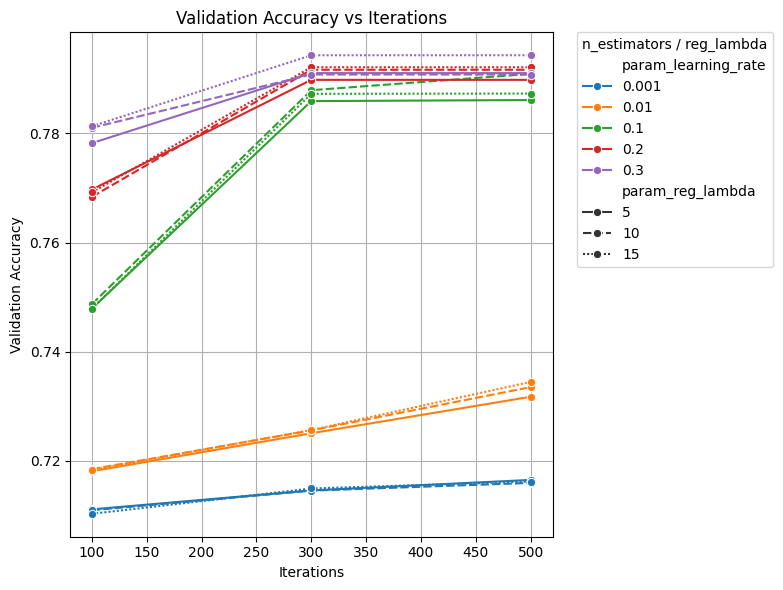

In [62]:
#Let's plot the new results
result=pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x=result['param_n_estimators'],y=result['mean_test_score'],hue=result['param_learning_rate'],style=result['param_reg_lambda'],marker="o",
    palette="tab10")
plt.title("Validation Accuracy vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Validation Accuracy")
plt.grid(True)
#plt.legend(title="n_estimators")
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    title="n_estimators / reg_lambda"
)

plt.tight_layout()
plt.show()


Now, lets run the XGBoosts with all the  best parameters from above grid search

In [ ]:
print(result.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_n_estimators', 'param_reg_lambda',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


In [63]:
model_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    gamma=1,
    max_depth=10,
    min_child_weight=20,
    learning_rate=0.3,
    reg_lambda=15,
    n_estimators=300,
    early_stopping_rounds=10

)


model_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)]
)

[0]	validation_0-logloss:0.62620
[1]	validation_0-logloss:0.58922
[2]	validation_0-logloss:0.56668
[3]	validation_0-logloss:0.55235
[4]	validation_0-logloss:0.54191
[5]	validation_0-logloss:0.53510
[6]	validation_0-logloss:0.53011
[7]	validation_0-logloss:0.52503
[8]	validation_0-logloss:0.52235
[9]	validation_0-logloss:0.51842
[10]	validation_0-logloss:0.51692
[11]	validation_0-logloss:0.51317
[12]	validation_0-logloss:0.50834
[13]	validation_0-logloss:0.50600
[14]	validation_0-logloss:0.50173
[15]	validation_0-logloss:0.49987
[16]	validation_0-logloss:0.49712
[17]	validation_0-logloss:0.49512
[18]	validation_0-logloss:0.49321
[19]	validation_0-logloss:0.49131
[20]	validation_0-logloss:0.48888
[21]	validation_0-logloss:0.48711
[22]	validation_0-logloss:0.48454
[23]	validation_0-logloss:0.48270
[24]	validation_0-logloss:0.47983
[25]	validation_0-logloss:0.47818
[26]	validation_0-logloss:0.47609
[27]	validation_0-logloss:0.47429
[28]	validation_0-logloss:0.47202
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=20, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [64]:
#Now, let's see how much the accuracy improves from the above the grid search
y_hat=model_xgb.predict(X_test)
print("accuracy:",accuracy_score(y_test,y_hat))

accuracy: 0.8593069306930693


The accuracy improves from 0.84 to 0.859

We could try more variations, but due to limited computational power, this is where I will stop.